## Markowitz Efficient Frontier

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter as ff

In [2]:
def ticker_frame(tickers, start="2016-01-31", end="2021-02-01", source="yahoo"):
    stock_price = []

    for ticker in range(len(tickers)):
        price_data = pdr.DataReader(tickers[ticker], start=start, end=end, data_source=source)
        stock_price.append(price_data[["Adj Close"]])
    
    df = pd.concat(stock_price, axis=1)
    df.columns=tickers
    return df

In [3]:
tickers = ['GOOG', 'MSFT', 'AAPL', 'AMZN']
NUM_STOCKS = len(tickers)
df = ticker_frame(tickers)

In [4]:
df.head()

,GOOG,MSFT,AAPL,AMZN
Date,,,,
2016-02-01,752.000000,49.809887,22.301582,574.809998
2016-02-02,764.650024,48.253052,21.850603,552.099976
2016-02-03,726.950012,47.488289,22.283085,531.070007
2016-02-04,708.010010,47.342621,22.462126,536.260010
2016-02-05,683.570007,45.667427,21.862209,502.130005


In [5]:
log_returns = np.log(df/df.shift(1))
log_returns.head()

,GOOG,MSFT,AAPL,AMZN
Date,,,,
2016-02-01,NaN,NaN,NaN,NaN
2016-02-02,0.016682,-0.031754,-0.020429,-0.040310
2016-02-03,-0.050561,-0.015976,0.019599,-0.038835
2016-02-04,-0.026399,-0.003072,0.008003,0.009725
2016-02-05,-0.035129,-0.036026,-0.027071,-0.065760


In [6]:
np.random.seed(10)
num_ports = 10000
all_weights = np.zeros((num_ports, len(df.columns)))
return_array = np.zeros(num_ports)
volume_array = np.zeros(num_ports)
sharpe_array = np.zeros(num_ports)

In [7]:
for i in range(num_ports):
    weights = np.array(np.random.random(NUM_STOCKS))
    weights = weights/np.sum(weights)
    
    all_weights[i,:] = weights
    return_array[i] = np.sum((log_returns.mean() * weights * 252))
    
    volume_array[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    sharpe_array[i] = return_array[i]/volume_array[i]

In [8]:
print("Max sharpe ratio in the array: {}".format(sharpe_array.max()))
print("Location in the array: {}".format(sharpe_array.argmax()))

Max sharpe ratio in the array: 1.3340795377830632
Location in the array: 695


In [9]:
print(all_weights[sharpe_array.argmax(), :])

max_sharpe_ratio_return = return_array[sharpe_array.argmax()]
max_sharpe_ratio_volume = volume_array[sharpe_array.argmax()]

[0.00180918 0.18486749 0.39962458 0.41369875]


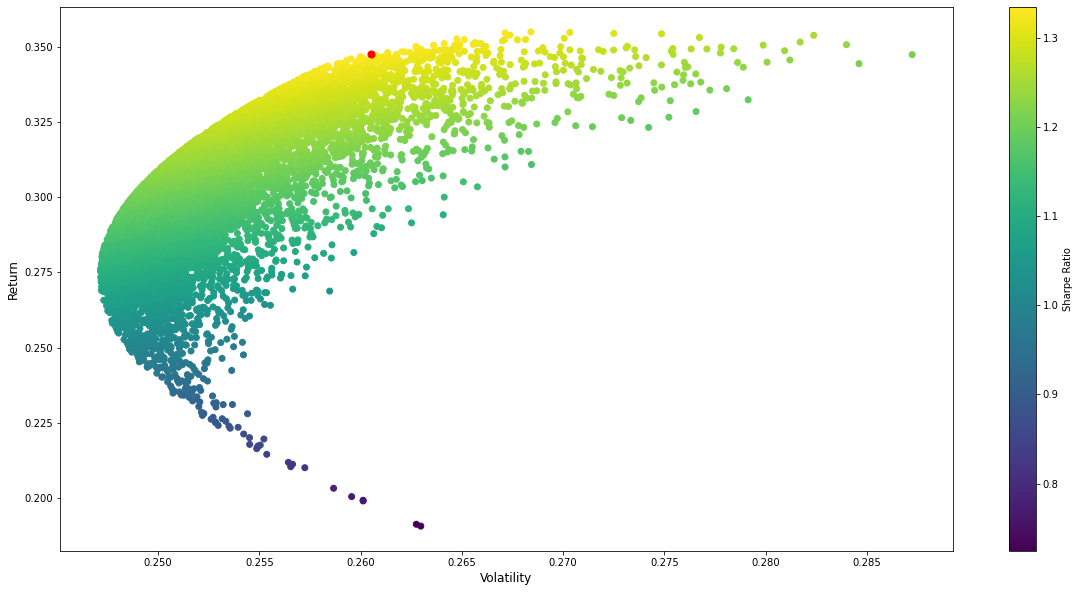

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(volume_array, return_array, c=sharpe_array, cmap="viridis")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.scatter(max_sharpe_ratio_volume, max_sharpe_ratio_return, c="red", s=50)
plt.show()

In [11]:
def get_return_volume_sharpe_ratio(weights):
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volume = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = returns/volume
    return np.array([returns, volume, sharpe_ratio])

def negative_sharpe_ratio(weights):
    return get_return_volume_sharpe_ratio(weights)[2] * - 1

def check_sum(weights):
    return np.sum(weights)-1

In [12]:
cons = ({"type": "eq", "fun": check_sum})
bounds = ((0,1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25, 0.25, 0.25, 0.25]

In [13]:
def minimize_volatility(weights):
    return get_return_volume_sharpe_ratio(weights)[1]

In [14]:
opt_results = minimize(negative_sharpe_ratio, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.3348692255057912
     jac: array([ 3.32187697e-01,  5.08427620e-05, -3.72335315e-04,  3.50534916e-04])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.        , 0.16280821, 0.41743363, 0.41975816])


In [15]:
get_return_volume_sharpe_ratio(opt_results.x)

array([0.34882551, 0.26131811, 1.33486923])

In [24]:
frontier_y = np.linspace(0.19, 0.3558955, 500)

In [26]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_return_volume_sharpe_ratio(w)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

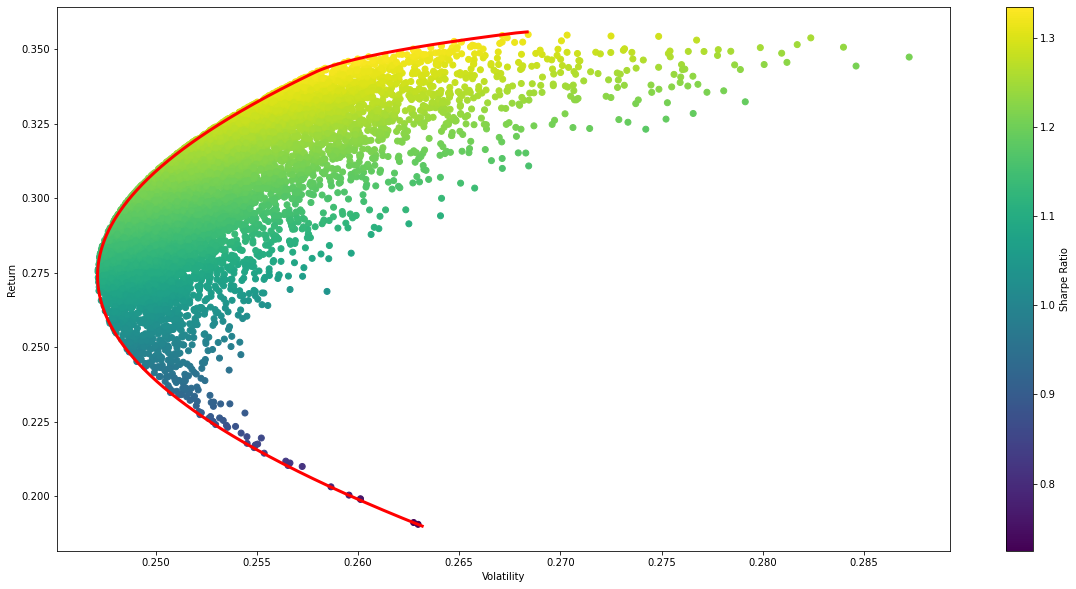

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(volume_array, return_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r', linewidth=3)
plt.savefig('cover.png')
plt.show()